## Clustering conformations using distances between atoms

This tutorial showcase the example where calculated features such as any distances can be used to perform the conformational clustering. The advantages is that it can be used to filter-out parts of the trajectory based on the given features. Since, trajectories could be separated, further analysis can be perofrmed on filtered trajectory.

### Instructions
* **Tutorial files**: The tutorial files can be downloaded from [here](https://figshare.com/ndownloader/files/55459325).
* **Extract the files**: `tar -zxvf distances.tar.gz`
* **Go to directory**: `cd distances`
* **Copy the Jupyter Notebook**: This notebook is available in the GitHub repo. [Download and copy it from the github](https://github.com/rjdkmr/gmx_clusterByFeatures/tree/master/docs/tutorials).

### Required Tools
* GROMACS
* gmx_clusterByFeatures

### Steps
In this tutorial, conformations of G-Quadruplex DNA is clustered according to distances between three atom-pairs. These atom-pairs form hydrogen bonds during the simulations. However, only one atom-pair among them could form hydrogen bond at a time or neither of them ccould form hydrogen bond. The formation of hydrogen bonds are extremely fluctuating between these atom-pairs, and therefore, clustering will filter conformations based on these hydrogen bonds and distances between atom-pairs.
1. Calculation of distances
2. Preparation of feature input file
3. Clustering using three distances
4. Analysis

### 1. Calculation of distances
<img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/h-bond-distances.png" width="1000"/>

We will use the GROMACS command `gmx pairdist` ro calculate these three distances between these three atom-pairs as described in following.

In [1]:
%%bash

gmx pairdist -s inputs/dna_ion.tpr -f inputs/dna_ion_combine.xtc -ref "resid 1 and atomname N7"  -sel "resid 17 and atomname H62" -o r1N7-r17H62
gmx pairdist -s inputs/dna_ion.tpr -f inputs/dna_ion_combine.xtc -ref "resid 1 and atomname H62" -sel "resid 17 and atomname N3"  -o r1H62-r17N3
gmx pairdist -s inputs/dna_ion.tpr -f inputs/dna_ion_combine.xtc -ref "resid 1 and atomname H61" -sel "resid 17 and atomname N1"  -o r1H61-r17N1

                     :-) GROMACS - gmx pairdist, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/distances
Command line:
  gmx pairdist -s inputs/dna_ion.tpr -f inputs/dna_ion_combine.xtc -ref 'resid 1 and atomname N7' -sel 'resid 17 and atomname H62' -o r1N7-r17H62

Reading file inputs/dna_ion.tpr, VERSION 2016.5 (single precision)
Reading file inputs/dna_ion.tpr, VERSION 2016.5 (single precision)
Reading frame   40000 time 800000.000   
Analyzed 40639 frames, last time 812760.000

GROMACS reminds you: "Load Up Your Rubber Bullets" (10 CC)

                     :-) GROMACS - gmx pairdist, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/distances
Command line:
  gmx pairdist -s inputs/dna_ion.tpr -f inputs/dna_ion_combine.xtc -ref 'resid 1 and atomname H62' -sel 'resid 17 and atomname 

### 2. Preparation of feature input file
For clustering, these distances are required to put in a single file as the three features. We perform following steps to create a single feature file compatible with the gmx_clusterByFeatures:


In [2]:
%%bash

cat r1N7-r17H62.xvg  > distances.xvg
printf "\n& \n\n"   >> distances.xvg
cat r1H62-r17N3.xvg >> distances.xvg
printf "\n& \n\n"   >> distances.xvg
cat r1H61-r17N1.xvg >> distances.xvg
printf "\n& \n\n"   >> distances.xvg

### 3. Clustering using three distances

Now, we will perform clustering using [K-Means algorithm](https://en.wikipedia.org/wiki/K-means_clustering). One of the **drawback** of K-Means clustering is that the number of clusters should be known beforehand. To automate the decision about number of clusters, `gmx_clusterByFeatures` implements several [cluster metrics](https://gmx-clusterbyfeatures.readthedocs.io/en/latest/commands/cluster.html#cmetric-prior). We will use option `-cmetric ssr-sst` to use the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering).

Following command will perform the clustering of conformations using firt 10 PCs projection. Explanation of options are as follows:
* `-method kmeans`: Use K-Means clustering algorithm
* `-ncluster 10`: K-Means clustering will be performed for 1 upto 10 clusters times each time. Finally, based on `-ssrchange` option, final number of clusters will be automatically selected.
* `-cmetric ssr-sst`: Use Elbow method to decide final number of clusters.
* `-nfeature 3`: There are three distances as the features for clustering.
* `-sort features`: Sort the output clustered trajectory based on the distance in feature space from its central structure.
* `-fit2central`: Fit/Superimpose the conformation on central structure in output clustered trajectory.
* `-ssrchange 2`: Threshold (percentage) of change in SSR/SST ratio in Elbow method to decide the number of clusters.
* `-cpdb clustered-trajs/central.pdb`: Dump central conformation of each cluster as a separate pdb file.
* `-fout clustered-trajs/cluster.xtc`: Dump conformations of each cluster as the separate trajectory file.
* `-plot pca_cluster.png`: Plot the feature-space (here, it will plot distance vs distance for all three combinations) coloured by the clusters.

**index group order**

1. **First index** group - Output group of atoms in the central structures and clustered trajectories

2. **Second index** group - Group of atoms to calculate RMSD between central conformations of clusters as RMSD matrix, which is dumped in the **log file** with `-g` option. Here, it is C-alpha atoms of protein. 
    
3. **Third index** group - Used for Superposition by least-square fitting. ONLY used in separate clustered trajectories to superimpose conformations on the central structure.


In [3]:
%%bash

# create a new folder to contain clustered trajectory and pdb files
mkdir clustered-trajs

echo 0 1 7 | gmx_clusterByFeatures cluster -s inputs/dna_ion.tpr -f inputs/dna_ion_combine.xtc -n inputs/dna_ion.ndx -feat distances.xvg \
                                           -method kmeans -nfeature 3 -cmetric ssr-sst -ncluster 10 -fit2central \
                                           -sort features -ssrchange 2 -cpdb clustered-trajs/central.pdb \
                                           -fout clustered-trajs/cluster.xtc -plot features_cluster.png \

 :-) GROMACS - gmx_clusterByFeatures cluster, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures cluster
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/distances
Command line:
  'gmx_clusterByFeatures cluster' -s inputs/dna_ion.tpr -f inputs/dna_ion_combine.xtc -n inputs/dna_ion.ndx -feat distances.xvg -method kmeans -nfeature 3 -cmetric ssr-sst -ncluster 10 -fit2central -sort features -ssrchange 2 -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc -plot features_cluster.png


         :-)  gmx_clusterByFeatures cluster (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_clusterByFeatures is 

  Cluster Log output   

Command:
'gmx_clusterByFeatures cluster' -s inputs/dna_ion.tpr -f inputs/dna_ion_combine.xtc -n inputs/dna_ion.ndx -feat distances.xvg -method kmeans -nfeature 3 -cmetric ssr-sst -ncluster 10 -fit2central -sort features -ssrchange 2 -cpdb clustered-trajs/central.pdb -fout clustered-trajs/cluster.xtc -plot features_cluster.png

Choose a group for the output:
Selected 0: 'System'

Choose a group for clustering/RMSD calculation:
Selected 1: 'DNA'

Choose a group for fitting or superposition:
Selected 7: 'r_2-4_r_6-7_r_9_r_11-13_r_18-20_&_!O1P_O2P_P_O5'_C5'_C4'_C3'_C2'_C1'_O4'_O3'_H*'


 Input Trajectory dt = 20 ps



###########################################
########## NUMBER OF CLUSTERS : 1 ########
###########################################

Cluster-ID	TotalFrames
1		40639



###########################################
########## NUMBER OF CLUSTERS : 2 ########
###########################################

Cluster-ID	TotalFrames
1		29163
2		11476



##########

Reading frame       4 time 787380.000   <string>:127: MatplotlibDeprecationWarning: The non_interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.NON_INTERACTIVE)`` instead.
Reading frame   40000 time 712940.000   
GROMACS reminds you: "You Fill Your Space So Sweet" (F. Apple)





Cluster-ID	Central Frame	Total Frames 
1		27707		15640
2		19707		8435
3		2166		6343
4		24630		5325
5		39369		4896



Extracting coordinates of the central structure...


Calculating RMSD between central structures...


 Central structurs - RMSD matrix 
    c1     c2     c3     c4     c5 
 0.000  0.522  0.192  0.266  0.401 
 0.522  0.000  0.562  0.453  0.408 
 0.192  0.562  0.000  0.271  0.418 
 0.266  0.453  0.271  0.000  0.385 
 0.401  0.408  0.418  0.385  0.000 


Writing central structure to pdb-files...


Writing trajectory for each cluster...


#### Number of clusters
As can be seen above in the Cluster Metrics Summary, both **Silhouette** and **Davies-Bouldin** score is best when 5 clusters are generated. Using Elbow method also, same number of clusters have been automatically decided. Therefore, for this purpose, total number of clusters should be 5 according to the cluster-metrics.


### 4. Analysis

We will perform following analyses on how the above clustering is able to separate conformations based on these three distances.
1. **Mapping of cluster with the distances as a function of time**
2. **Distribution of distance cluster-wise**

**Setup for analysis:** At first, we defined few Python functions to read the file in Python.

In [4]:
import re
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def read_clid(filename):
    ''' Read the clid.xvg file

    It returns the dictionary listing all the frame indices belonging to that given cluster.

    Returns
    -------
    Dictionary of clid to index
    '''

    fin = open(filename, 'r')

    data = dict()
    index = 0
    for line in fin:
        line = line.rstrip().lstrip()
        if not line:
            continue

        if re.search('^#|^@', line) is not None:
                    continue

        temp = re.split('\s+', line)

        clid = int(temp[1])

        if clid not in data:
            data[clid] = [ index ]
        else:
            data[clid] = data[clid] + [ index ]

        index = index + 1

    return data


def read_xvg(filename):
    ''' Read any XVG file and return the data as 2D array where data is row-wise with respect to time.
    '''
    fin = open(filename, 'r')

    data = []
    for line in fin:
        line = line.rstrip().lstrip()
        if not line:
            continue

        if re.search('^#|^@', line) is not None:
                     continue

        temp = re.split('\s+', line)
        data.append(list(map(float, temp)))

    data = np.asarray(data)

    return data.T

#### 1. Mapping of cluster with the distances as a function of time
Here, we will highlight the distances according to the clusters as a function of time.


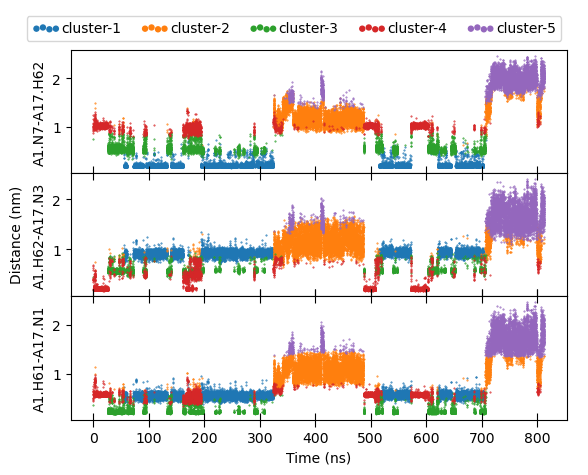

In [17]:
dist_files=["r1N7-r17H62", "r1H62-r17N3", "r1H61-r17N1" ]
labels =   ["A1.N7-A17.H62", "A1.H62-A17.N3", "A1.H61-A17.N1" ]
clid_index = read_clid("clid.xvg")
clid = list(sorted(clid_index.keys()))

fig = plt.figure()
fig.subplots_adjust(hspace=0)
axes=[]

for i in range(len(dist_files)):
    data = read_xvg(dist_files[i]+'.xvg')
    data[0] = data[0]/1000
    
    if i == 0:
        ax = fig.add_subplot(3,1,i+1)
    else:
        ax = fig.add_subplot(3,1,i+1, sharex=axes[0])
        ax.tick_params(axis='x', bottom=True, top=True, direction='inout', length=10)
    ax.set_ylabel(labels[i])
    axes.append(ax)
    
    plot_data = []
    time = []
    for ix in clid:
        plot_data.append(data[1][clid_index[ix]])
        time.append(data[0][clid_index[ix]])
        ax.scatter(time, plot_data, label='cluster-{0}'.format(ix), s=0.2)
        plot_data = []
        time = []
        
    if i==0:
        handles, legend_labels = ax.get_legend_handles_labels()



axes[2].set_xlabel('Time (ns)')
fig.text(0.03, 0.4,'Distance (nm)', rotation='vertical')

fig.legend(handles, legend_labels, ncol=5, loc='upper center',scatterpoints=4,markerscale=8, handletextpad=0.1, 
           columnspacing=1.4, handlelength=2, borderaxespad=1.2)


plt.savefig('distance_cluster.png', dpi=300)
plt.show()

#### 2. Distribution of distance cluster-wise

We will calculate and plot distribution of all three distances with respect to each cluster. It will demonstrate that which distance is filtered out in which cluster more easily.

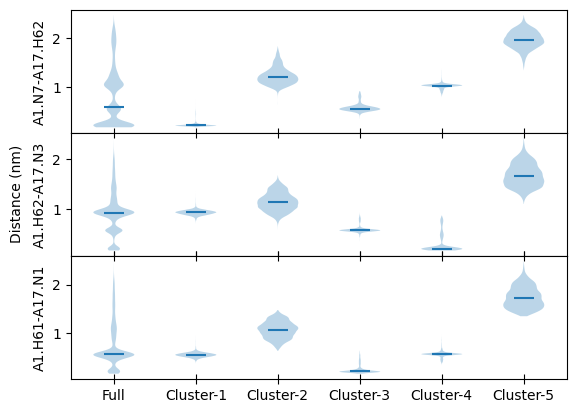

In [23]:
fig = plt.figure()
fig.subplots_adjust(hspace=0)
axes=[]

for i in range(len(dist_files)):
    clid = list(sorted(clid_index.keys()))
    data = read_xvg(dist_files[i]+'.xvg')

    if i == 0:
        ax = fig.add_subplot(3,1,i+1)
    else:
        ax = fig.add_subplot(3,1,i+1, sharex=axes[0])
        ax.tick_params(axis='x', bottom=True, top=True, direction='inout', length=7)
    ax.set_ylabel(labels[i])
    axes.append(ax)


    plot_data = []
    plot_data.append(data[1])
    for ix in clid:
        plot_data.append(data[1][clid_index[ix]])

    clid = [0] + clid
    ax.violinplot(plot_data, positions=clid, showmedians = True, showextrema=False,  points=500)

    xticks = []
    for c in clid:
        if c == 0:
            xticks.append('Full')
        else:
            xticks.append('Cluster-{0}'.format(c))
    ax.set_xticks([ cid for cid in clid])
    ax.set_xticklabels(xticks)

fig.text(0.03, 0.4,'Distance (nm)', rotation='vertical')
plt.savefig("distance_distribution.png", dpi=300)

**Above distance distributions clearly show:**
* **Cluster-1** : Hydrogen bond between A1.N7 and A17.H62
* **Cluster-2** : All three distances between 0.5 to 1.5 nm
* **Cluster-3** : Hydrogen bond between A1.H61 and A17.N1
* **Cluster-4** : Hydrogen bond between A1.H62 and A17.N3
* **Cluster-5** : All distances above 1.5 nm